# Photo-z data AugMent (PAM)

#### Setup:

Run `source setup.sh` from `bash` command line in kernel in order to setup paths for code.

## Create train/test catalogs

In [1]:
import os
import numpy as np
from create_cats import create_cats
%load_ext autoreload
%autoreload 2

### Create base catalog

In [6]:
# Catalog columns
names = ['index', 'redshift', 'u', 'g', 'r', 'i', 'z', 'y', 'g_abs', 'r_abs']

In [7]:
# Point to catalog
cat_name = 'Euclid_trim_27p5_3p5_short.dat'
filename = os.path.join(os.environ['PZ_CAT_FOLDER'], cat_name)
cc = create_cats(filename, names)

Training set size: 500000. Test set size: 2000000.


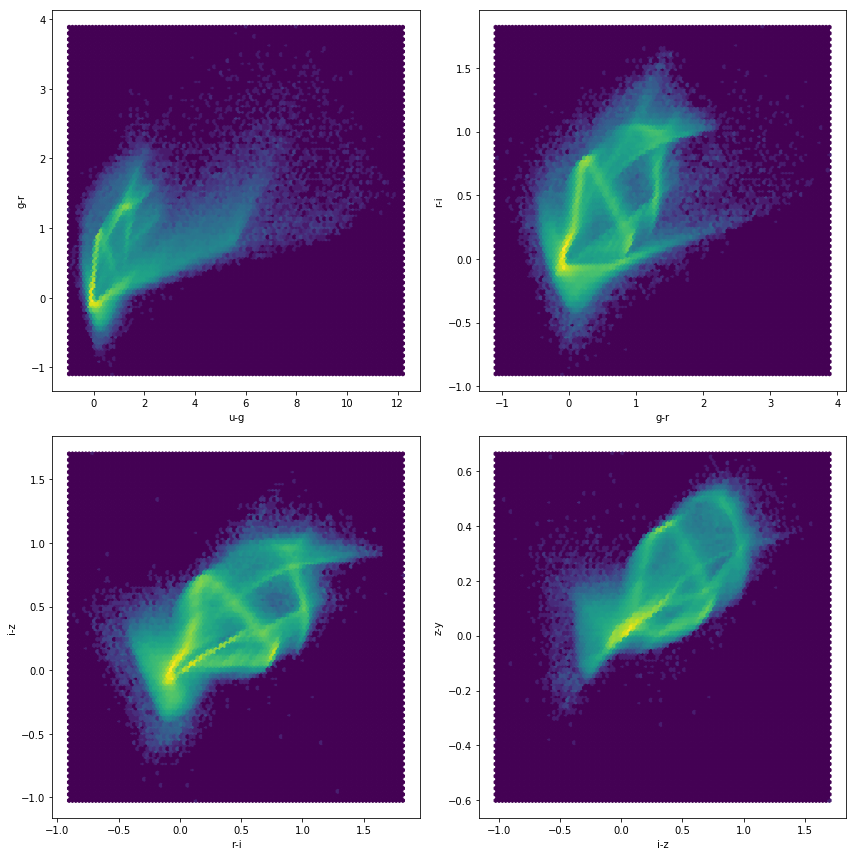

In [4]:
# Create a base train/test catalog with 500,000 objects in training set
# and remaining in test set
cc.create_base_cats('full', 500000, out_dir='../data', random_state=2136)

### Create alternative catalogs

In [5]:
# Sparse catalog, only 100000 training, no color cut, no redshift cut
cc.create_sparse_cats('sparse', 500000, sparsity=5,
                      out_dir='../data', random_state=2136)

NameError: name 'rand_state' is not defined

Color group histogram: 
(array([ 89042, 336619,  22396,  51943]), array([0.  , 0.75, 1.5 , 2.25, 3.  ]))
Removing Color Group 0
Training set size: 410958. Test set size: 2000000.


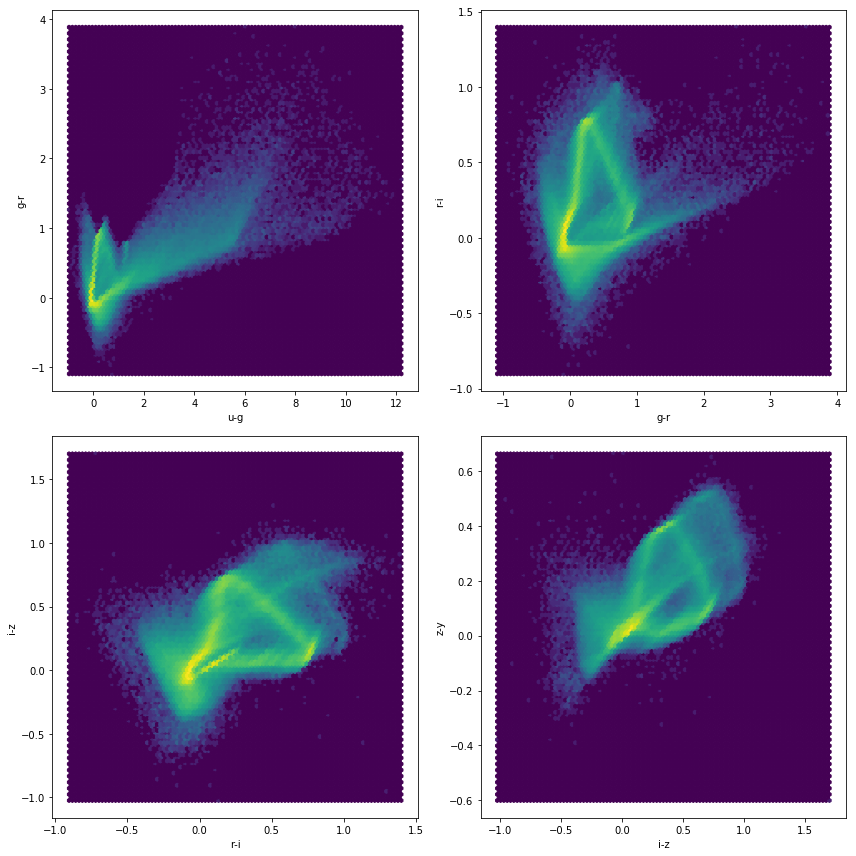

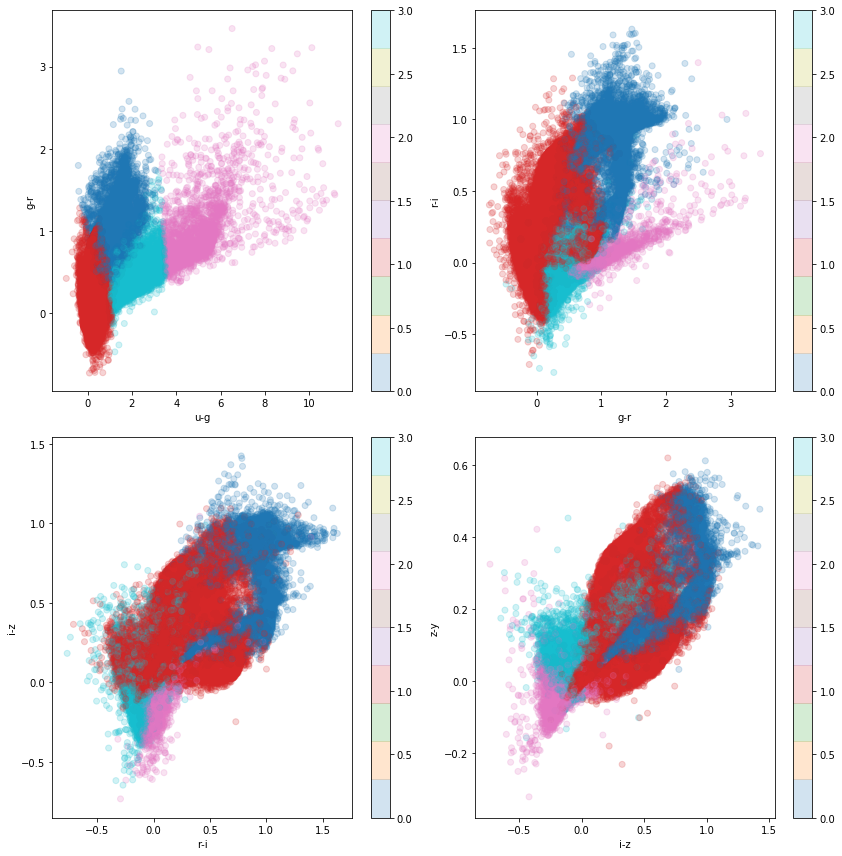

In [9]:
# Group color cut
cc.create_color_group_cats('4_group_color_cut_0', 500000, 4, choose_out=0,
                           out_dir='../data', random_state=2136)

0 2 500
Training set size: 460969. Test set size: 2000000.


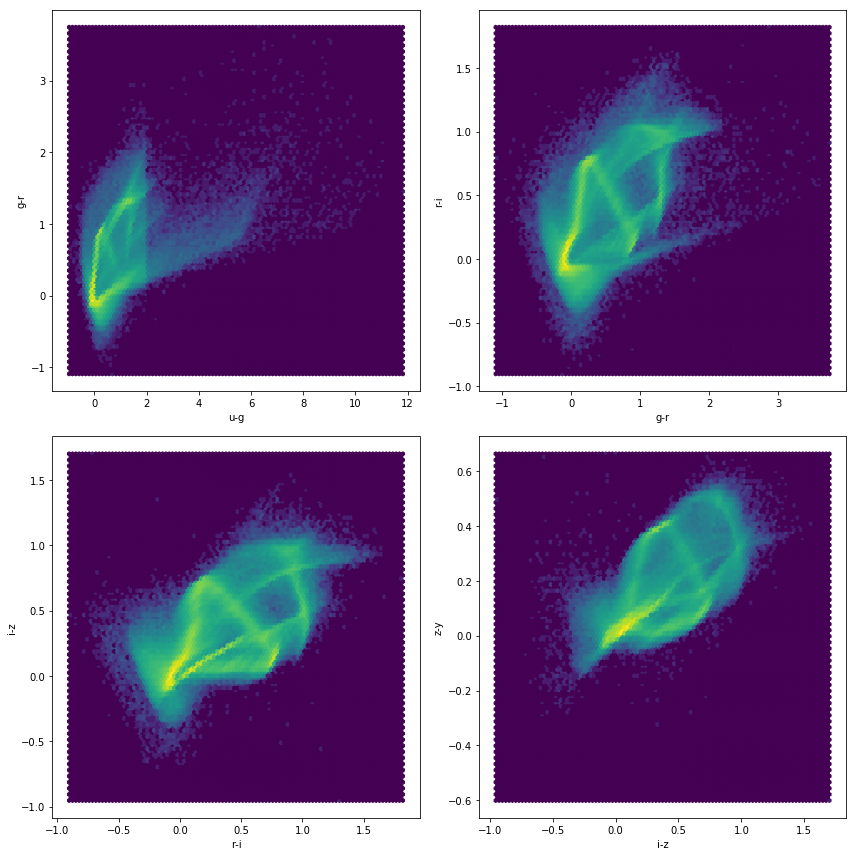

In [67]:
# Red color cut, u-g > 2. reduced by 80%
cc.create_color_cut_cats('ug_color_cut', 500000, [0], [2], [500], 
                         sparsity=[5], out_dir='../data', random_state=2136)

3 23 500
Training set size: 15778. Test set size: 2000000.


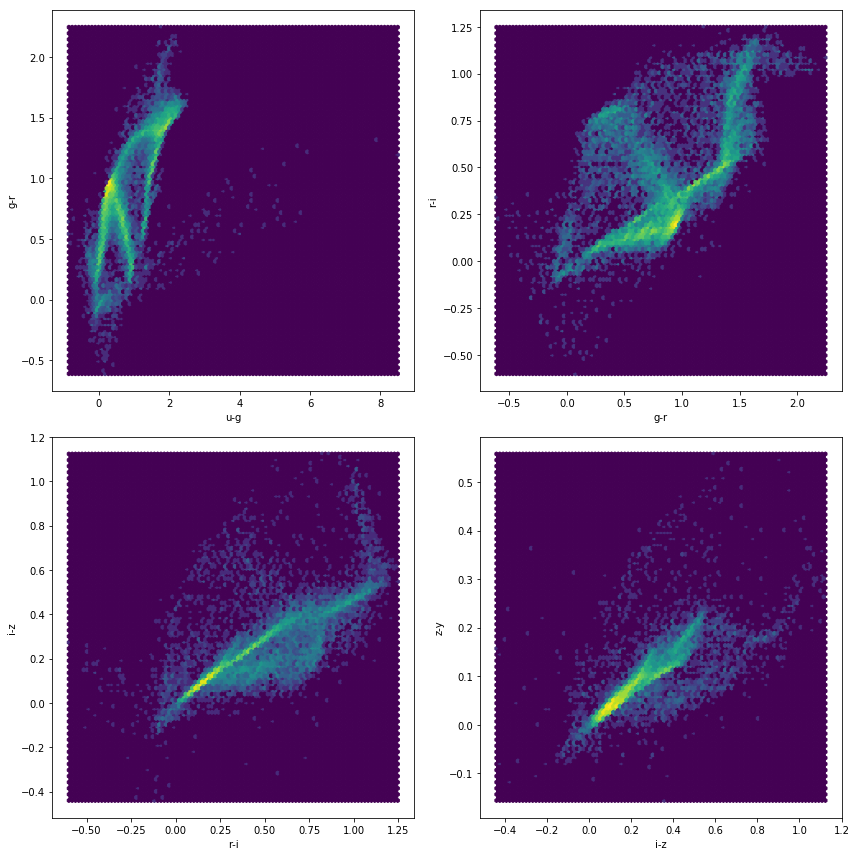

In [37]:
# Mag cut, no galaxies r < 23
cc.create_mag_cut_cats('r_23_mag_cut', 500000, ['r'], [23], [500], 
                         sparsity=None, out_dir='../data', random_state=2136)

3 22 23 2
3 23 500 10
Training set size: 59612. Test set size: 2000000.


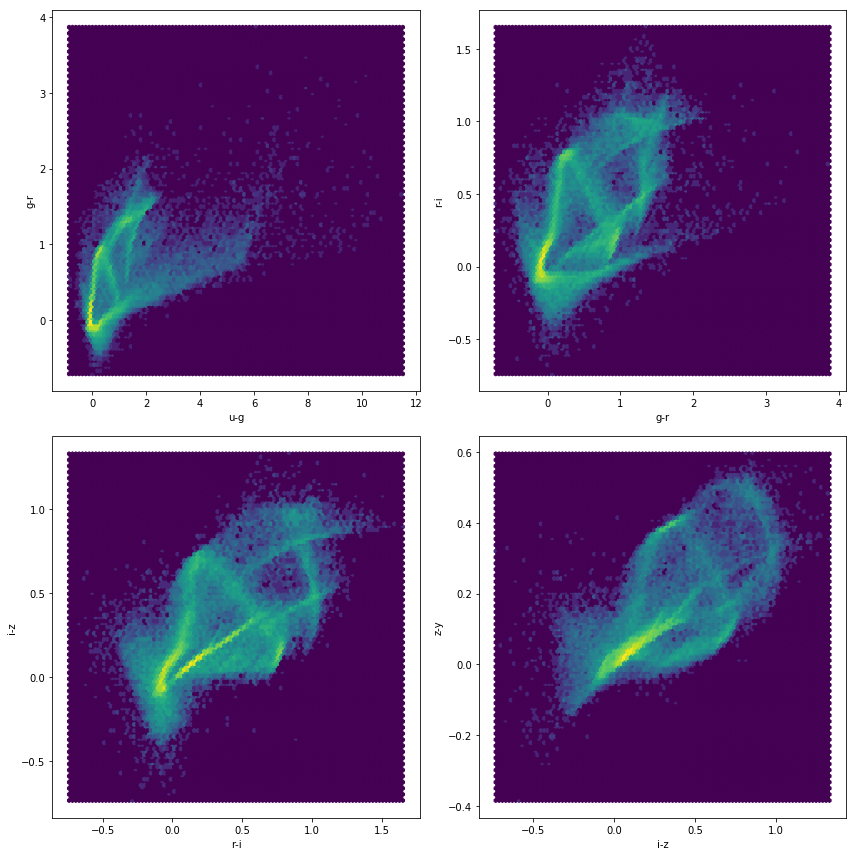

In [66]:
# Mag cut, 50% galaxies r < 22, 10% galaxies r < 23
cc.create_mag_cut_cats('r_23_mag_cut_keep_10', 500000, ['r', 'r'], [22, 23], [23, 500], 
                         sparsity=[2, 10], out_dir='../data', random_state=2136)

Training set size: 387691. Test set size: 2000000.


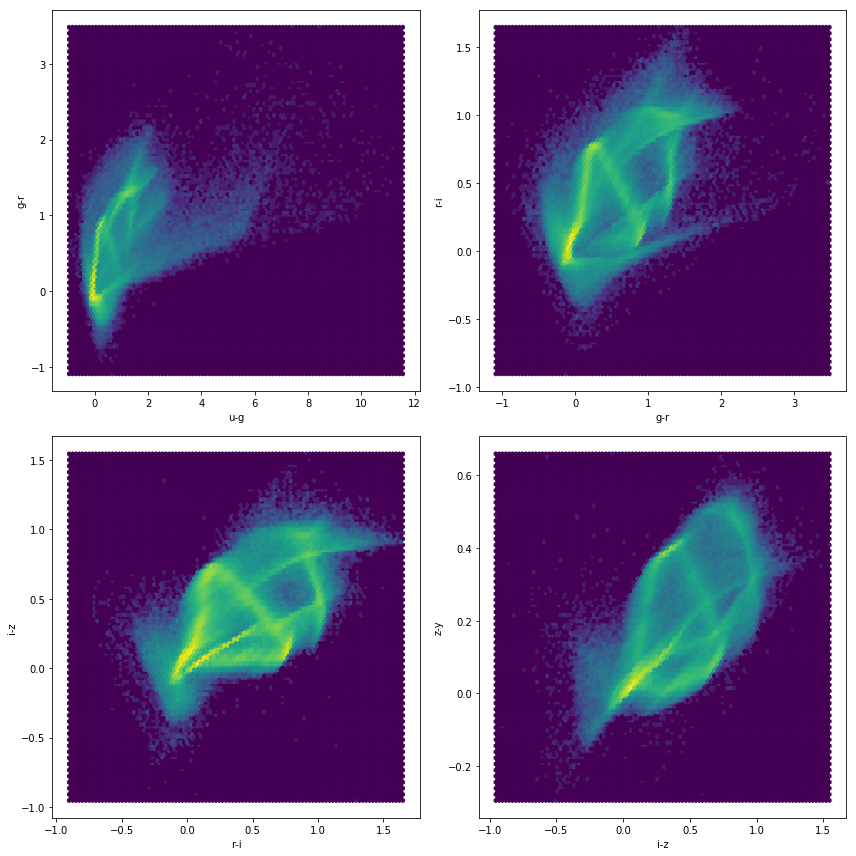

In [64]:
# Redshift cut, z > 2. reduced by 80%
cc.create_redshift_cut_cats('z_2_cut', 500000, 2.0, 5.0, sparsity=5,
                            out_dir='../data', random_state=2136)

Training set size: 359613. Test set size: 2000000.


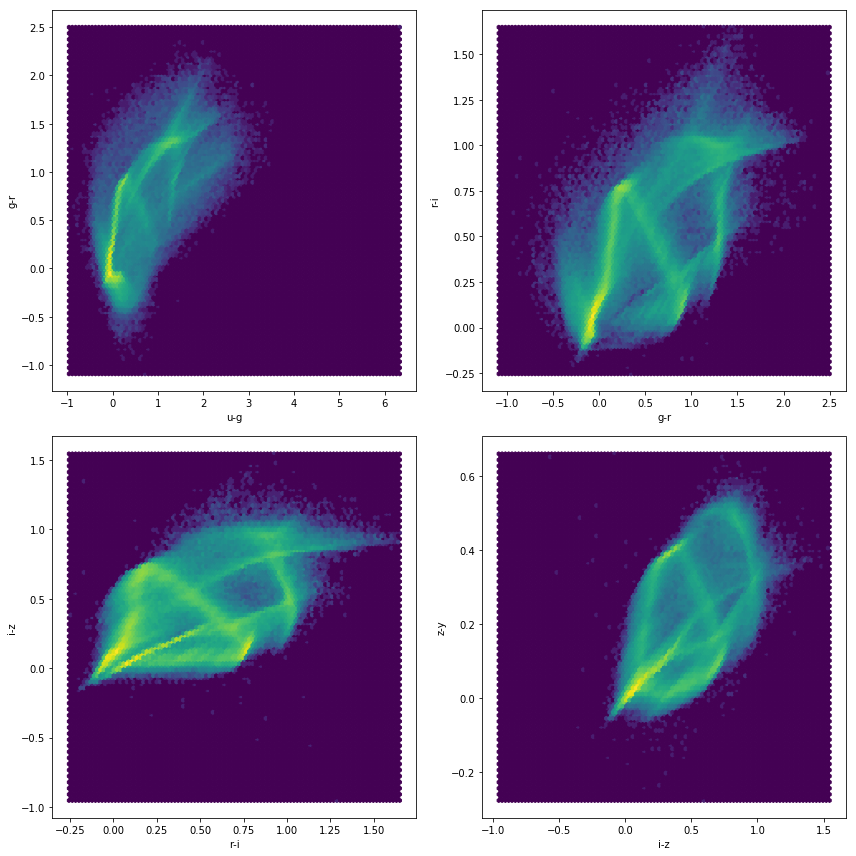

In [73]:
# Redshift cut, z > 2. reduced by 80%
cc.create_redshift_cut_cats('z_2_cut_all', 500000, 2.0, 5.0, sparsity=None,
                            out_dir='../data', random_state=2136)

## Train networks

In [4]:
import pandas as pd
from photoz_nn import photoz_nn

In [ ]:
for train_suffix, test_suffix in zip(['full', 'sparse', 'group_color_cut', 'ug_color_cut', 'z_2_cut'],
                                     ['full', 'full', 'full', 'full', 'full']):
    
    print(cat_suffix)
    pz_nn = photoz_nn(seed=1446)

    train_filename = '../data/train_cat_%s.dat' % cat_suffix
    train_colors, train_specz = pz_nn.load_catalog(train_filename)
    test_filename = '../data/test_cat_%s.dat' % cat_suffix
    test_colors, test_specz = pz_nn.load_catalog(test_filename)

    train_len = len(train_colors)
    test_len = len(test_colors)

    net = pz_nn.train_model(train_colors, train_specz)

    train_photoz = pz_nn.run_model(net, train_colors)
    test_photoz = pz_nn.run_model(net, test_colors)

    pz_nn.save_model(net, '../data/pz_network_%s.pt' % cat_suffix)

    train_results = {'true_z':train_specz.reshape(train_len),
                     'photo_z': train_photoz.reshape(train_len)}
    train_results_df = pd.DataFrame.from_dict(data=train_results)
    test_results = {'true_z':test_specz.reshape(test_len),
                    'photo_z': test_photoz.reshape(test_len)}
    test_results_df = pd.DataFrame.from_dict(data=test_results)
    train_results_df.to_csv('../data/train_results_%s.csv' % cat_suffix, index=False)
    test_results_df.to_csv('../data/test_results_%s.csv' % cat_suffix, index=False)

## Plot results

In [18]:
from plot_pz_nn import plot_pz_nn

In [19]:
plot_pz = plot_pz_nn()

In [75]:
# Load results into dictionary
import pandas as pd
train_results_dict = {}
test_results_dict = {}

for cat_suffix in ['full', 'group_color_cut_3', 'group_color_cut_1', 'r_23_mag_cut', 'r_23_mag_cut_keep_10',
                   'sparse', 'ug_color_cut', 'z_2_cut', 'z_2_cut_all']:
    train_results_dict[cat_suffix] = pd.read_csv('../data/train_results_%s.csv' % cat_suffix)
    test_results_dict[cat_suffix] = pd.read_csv('../data/test_results_%s.csv' % cat_suffix)

### Plot single results

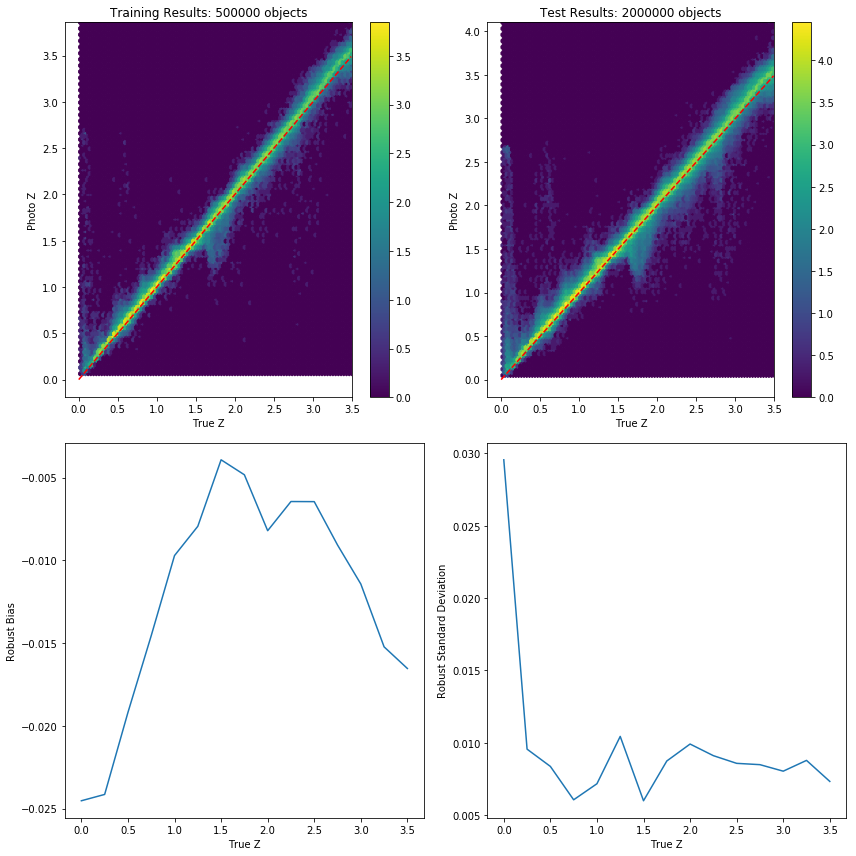

In [28]:
# full
cat_string = 'full'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

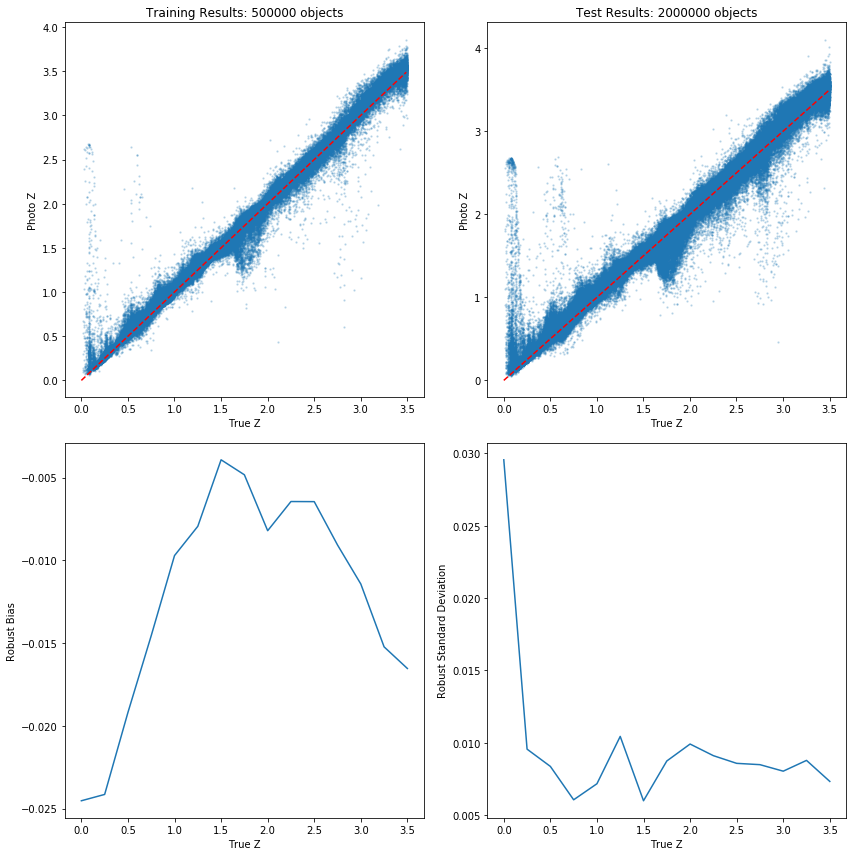

In [29]:
# full
cat_string = 'full'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string, density_plot=False)

/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:4676: RuntimeWarning: overflow encountered in log10
  accum = np.log10(accum + 1)
/epyc/opt/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:4676: RuntimeWarning: invalid value encountered in log10
  accum = np.log10(accum + 1)


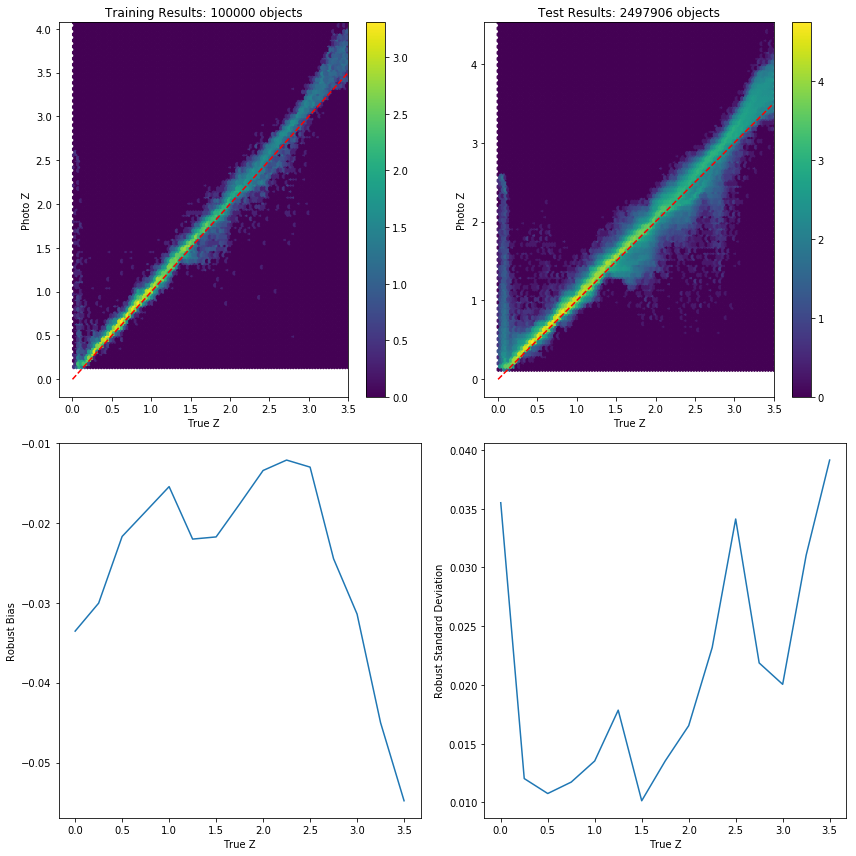

In [20]:
# sparse
cat_string = 'sparse'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

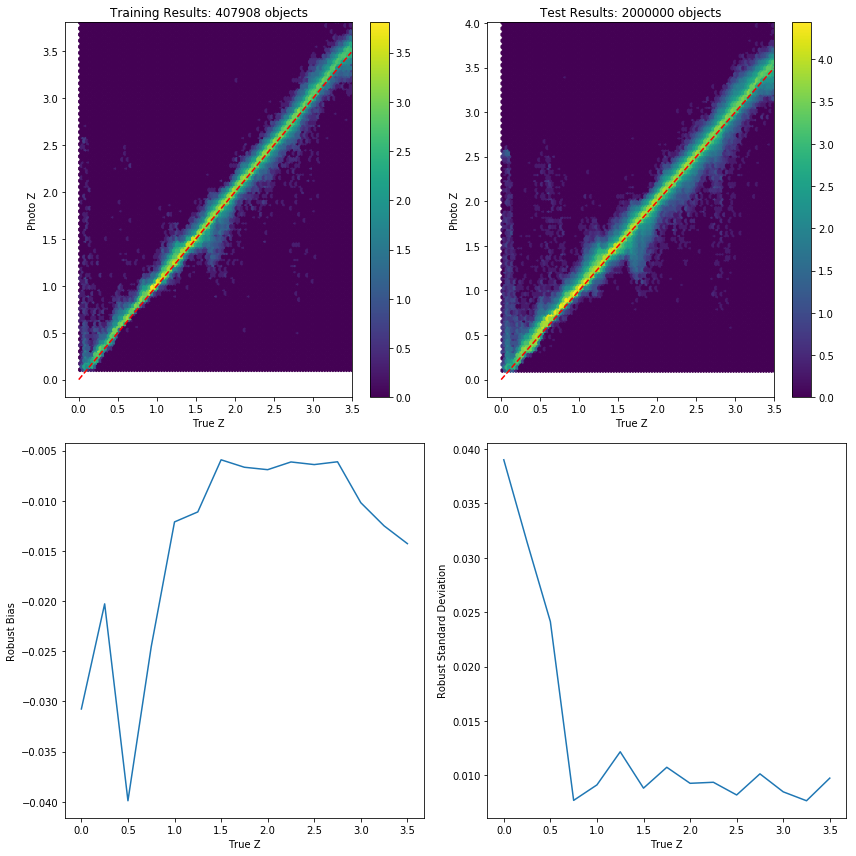

In [11]:
# group_color_cut_3
cat_string = 'group_color_cut_3'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

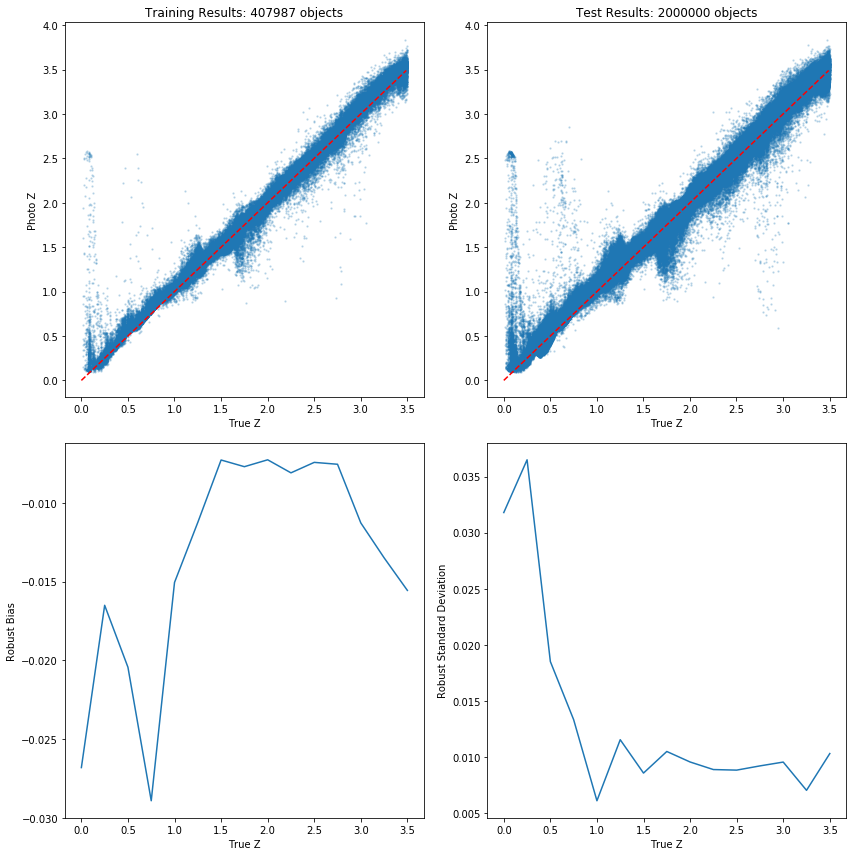

In [54]:
# group_color_cut_3
cat_string = 'group_color_cut_3'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string, density_plot=False)

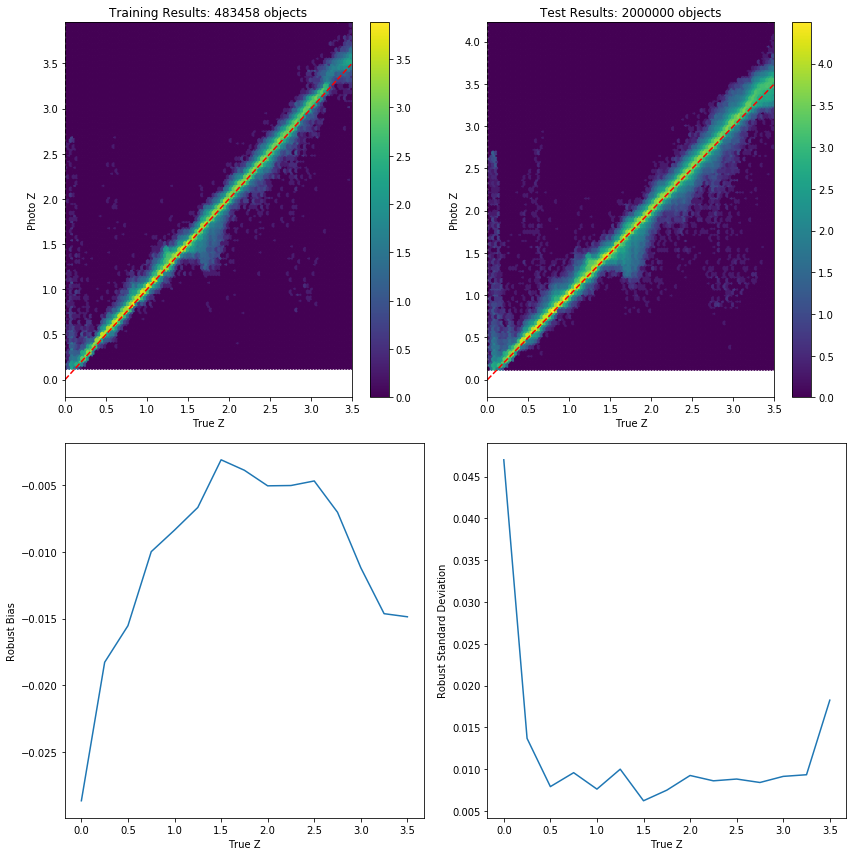

In [42]:
# group_color_cut_1
cat_string = 'group_color_cut_1'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string, density_plot=True)

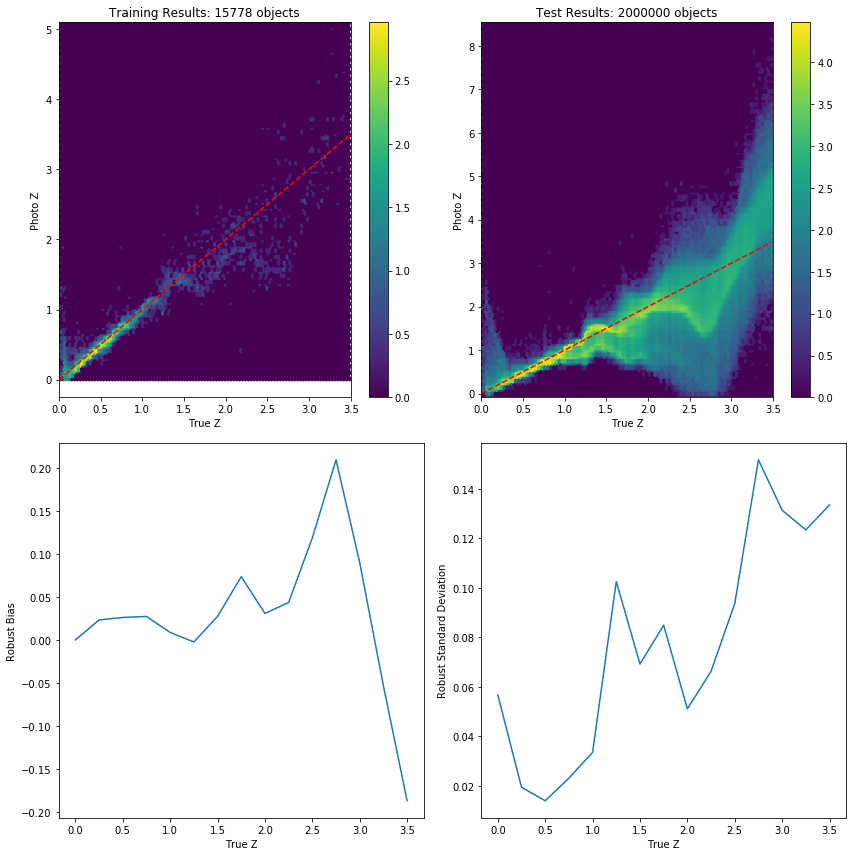

In [41]:
# mag_cut
cat_string = 'r_23_mag_cut'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

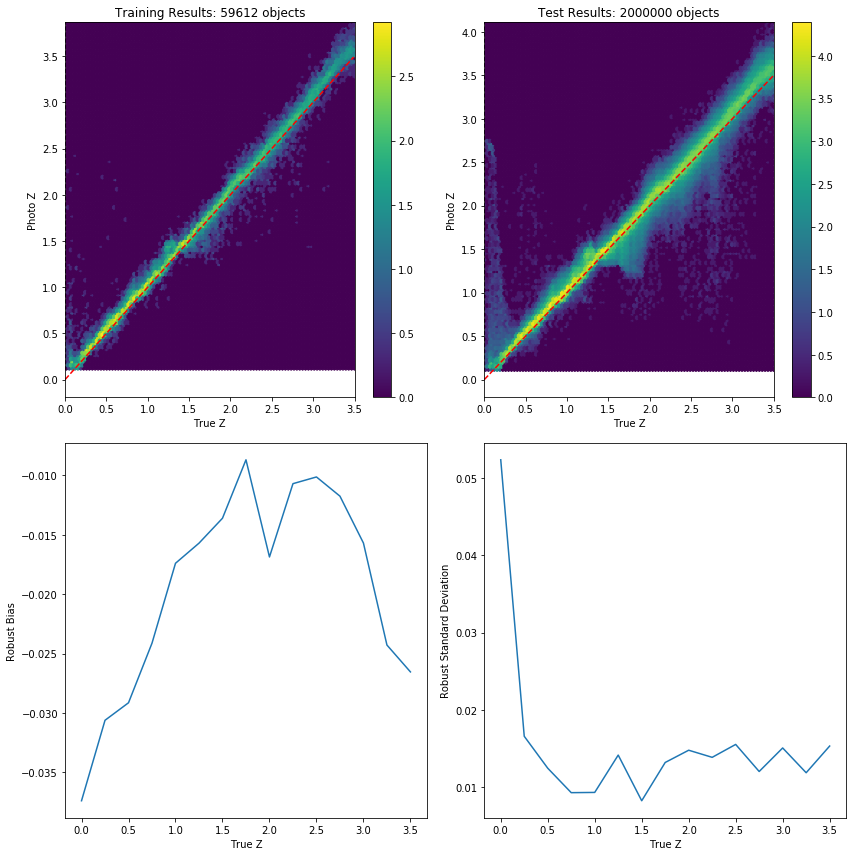

In [76]:
# mag_cut
cat_string = 'r_23_mag_cut_keep_10'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

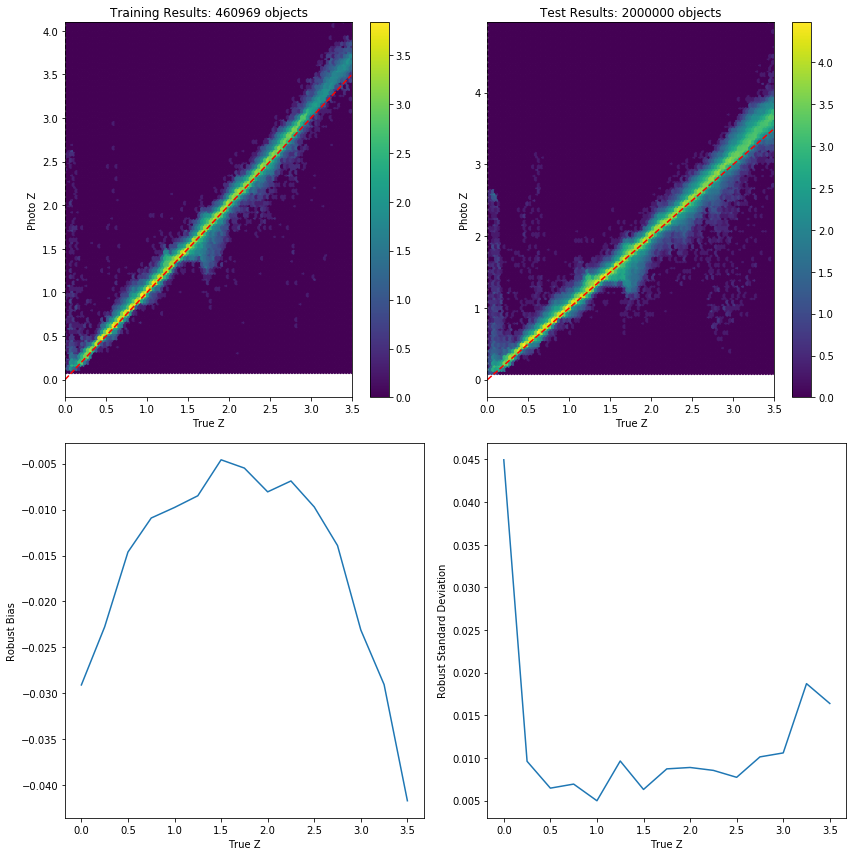

In [70]:
# ug_color_cut
cat_string = 'ug_color_cut'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

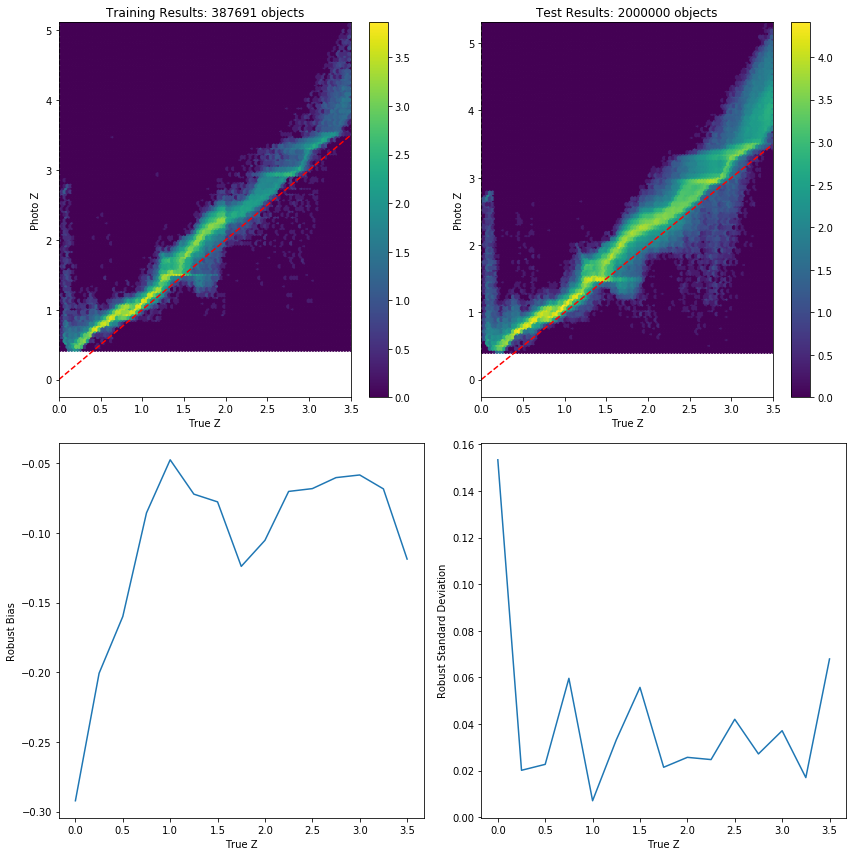

In [71]:
# z_2_cut
cat_string = 'z_2_cut'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

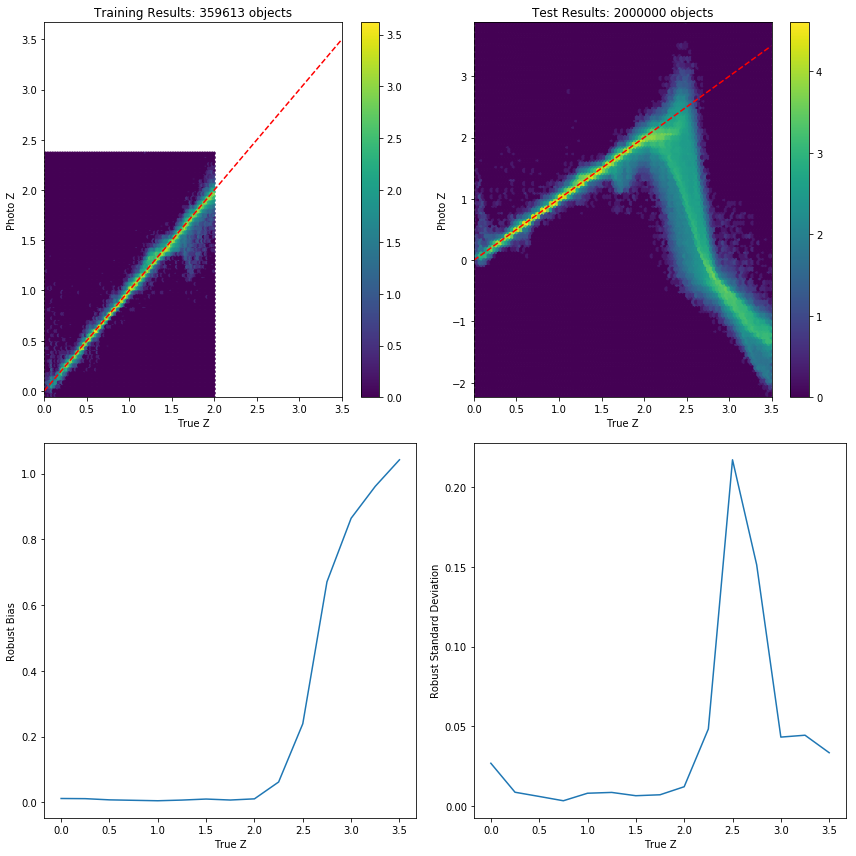

In [77]:
# z_2_cut_all
cat_string = 'z_2_cut_all'
plot_pz.plot_single_results(train_results_dict[cat_string], test_results_dict[cat_string],
                            '../data/%s_results.pdf' % cat_string)

### Compare Results

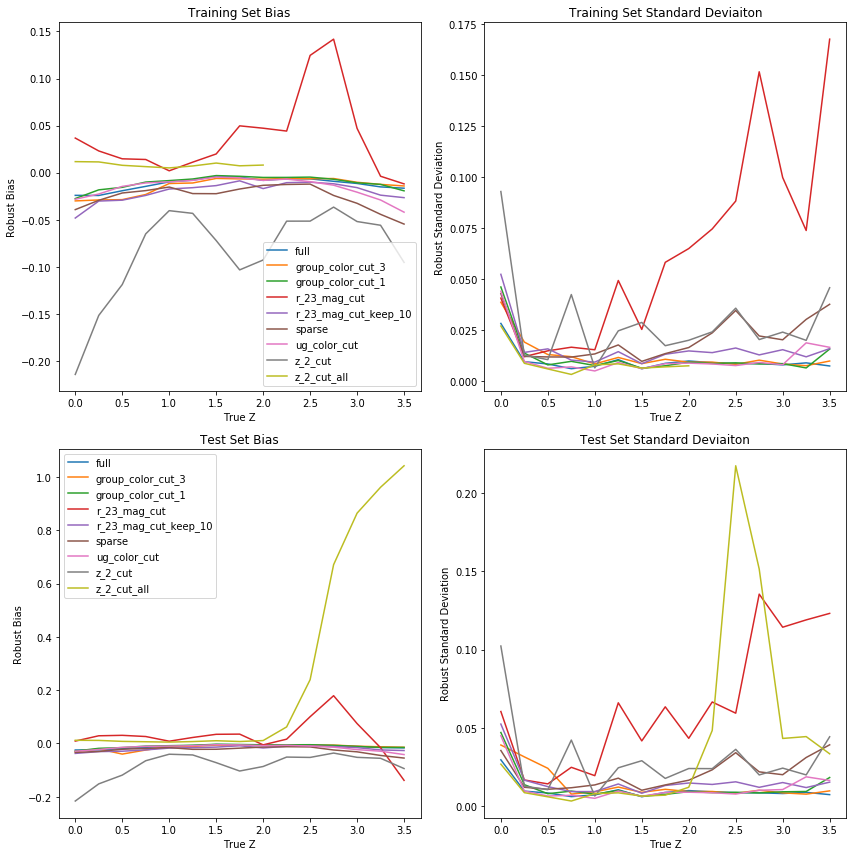

In [78]:
plot_pz.plot_multiple_results(list(train_results_dict.values()),
                              list(test_results_dict.values()),
                              list(train_results_dict.keys()),
                              '../data/compare_all.pdf')

#### Find regions where results are missing and compare

In [79]:
# Redshift comparison
test_full_df_redshift_cut = test_results_dict['full'].query('true_z > 2').reset_index(drop=True)
test_redshift_df = test_results_dict['z_2_cut'].query('true_z > 2').reset_index(drop=True)

In [81]:
# Redshift comparison
test_full_df_redshift_cut = test_results_dict['full'].query('true_z > 2').reset_index(drop=True)
test_redshift_df = test_results_dict['z_2_cut_all'].query('true_z > 2').reset_index(drop=True)

In [44]:
# Load color labels
color_labels = np.genfromtxt('../data/test_labels_group_color_cut_3.dat')
test_full_df_color_cut = test_results_dict['full'].iloc[np.where(color_labels == 3.)].reset_index(drop=True)
test_colors_df = test_results_dict['group_color_cut_3'].iloc[np.where(color_labels == 3.)].reset_index(drop=True)

In [50]:
# Load color labels
color_labels = np.genfromtxt('../data/test_labels_group_color_cut_1.dat')
test_full_df_color_cut = test_results_dict['full'].iloc[np.where(color_labels == 1.)].reset_index(drop=True)
test_colors_df = test_results_dict['group_color_cut_1'].iloc[np.where(color_labels == 1.)].reset_index(drop=True)

In [85]:
# Load color labels
mag_labels = np.genfromtxt('../data/test_labels_r_23_mag_cut.dat')
test_full_df_color_cut = test_results_dict['full'].iloc[np.where(mag_labels == 1.)].reset_index(drop=True)
test_colors_df = test_results_dict['r_23_mag_cut'].iloc[np.where(mag_labels == 1.)].reset_index(drop=True)

In [87]:
# Load color labels
mag_labels = np.genfromtxt('../data/test_labels_r_23_mag_cut_keep_10.dat')
test_full_df_color_cut = test_results_dict['full'].iloc[np.where(mag_labels == 1.)].reset_index(drop=True)
test_colors_df = test_results_dict['r_23_mag_cut_keep_10'].iloc[np.where(mag_labels == 1.)].reset_index(drop=True)

In [83]:
# Load color labels
color_labels = np.genfromtxt('../data/test_labels_ug_color_cut.dat')
test_full_df_color_cut = test_results_dict['full'].iloc[np.where(color_labels == 1.)].reset_index(drop=True)
test_colors_df = test_results_dict['ug_color_cut'].iloc[np.where(color_labels == 1.)].reset_index(drop=True)

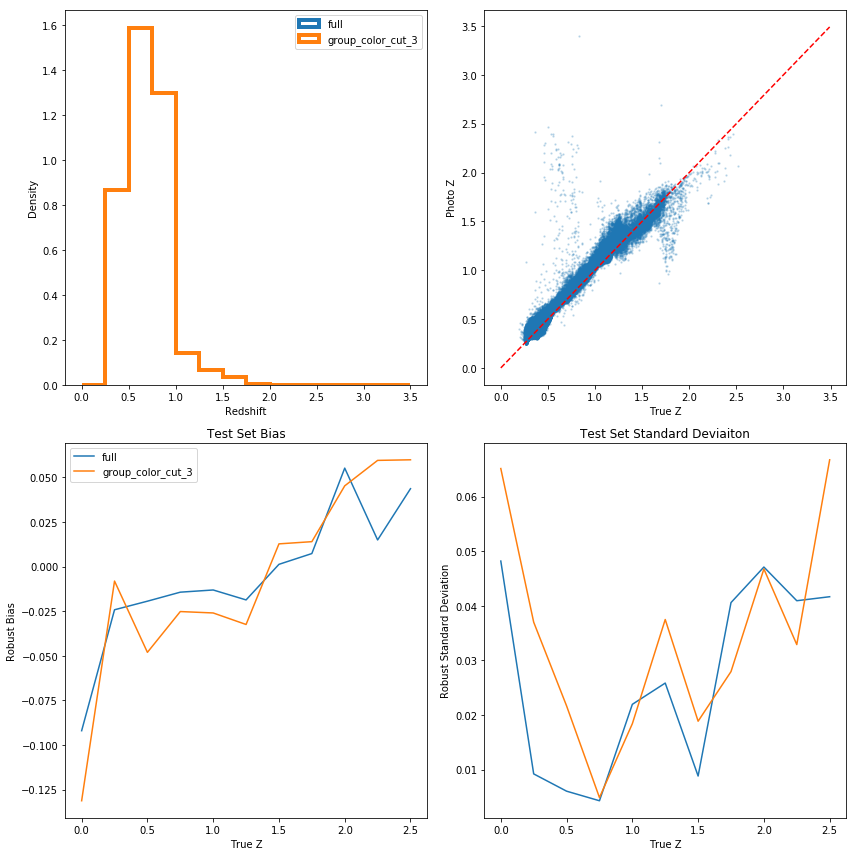

In [45]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df],
                         ['full', 'group_color_cut_3'],
                         '../data/compare_color_cut_3.pdf',  scatter_index=1)

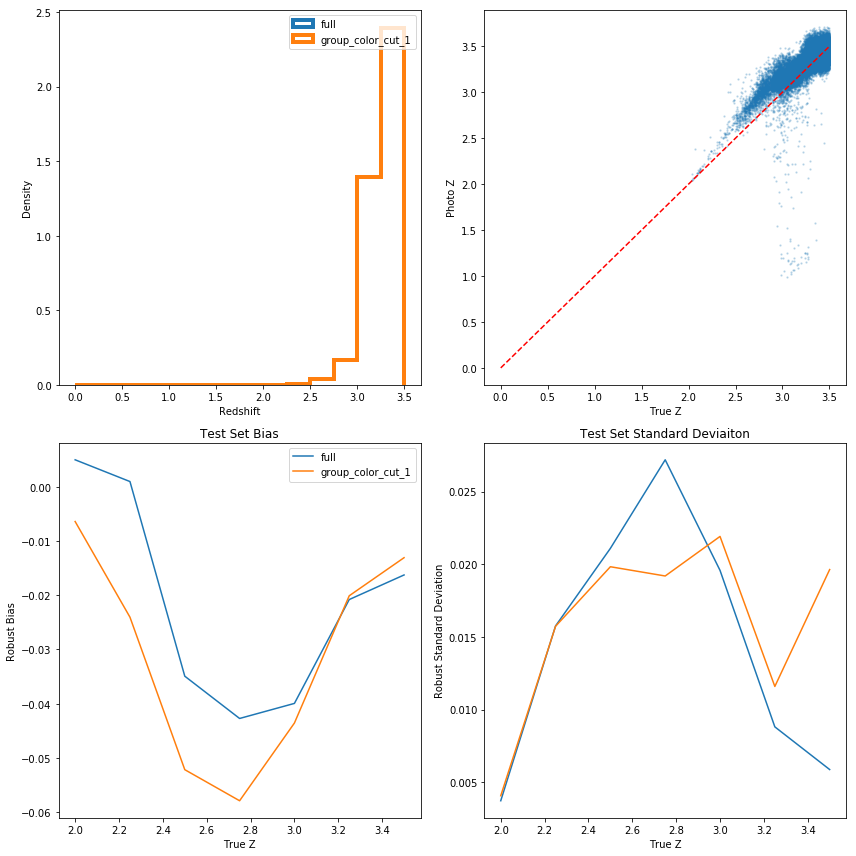

In [52]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df],
                         ['full', 'group_color_cut_1'],
                         '../data/compare_color_cut_1.pdf',  scatter_index=1)

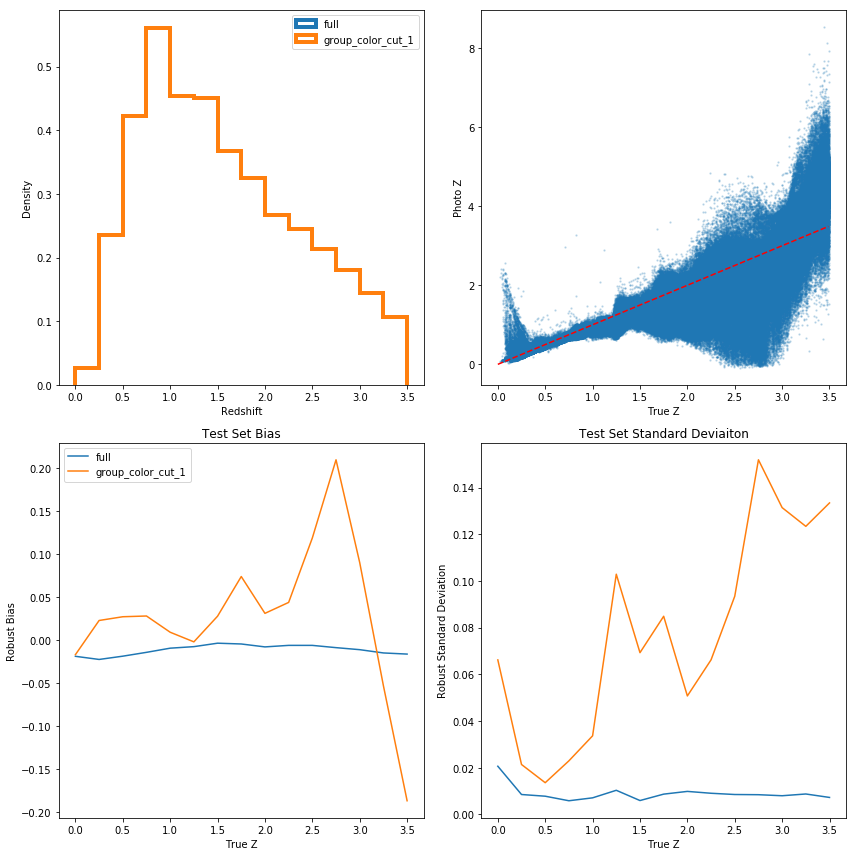

In [54]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df],
                         ['full', 'group_color_cut_1'],
                         '../data/compare_mag_cut_r_23.pdf',  scatter_index=1)

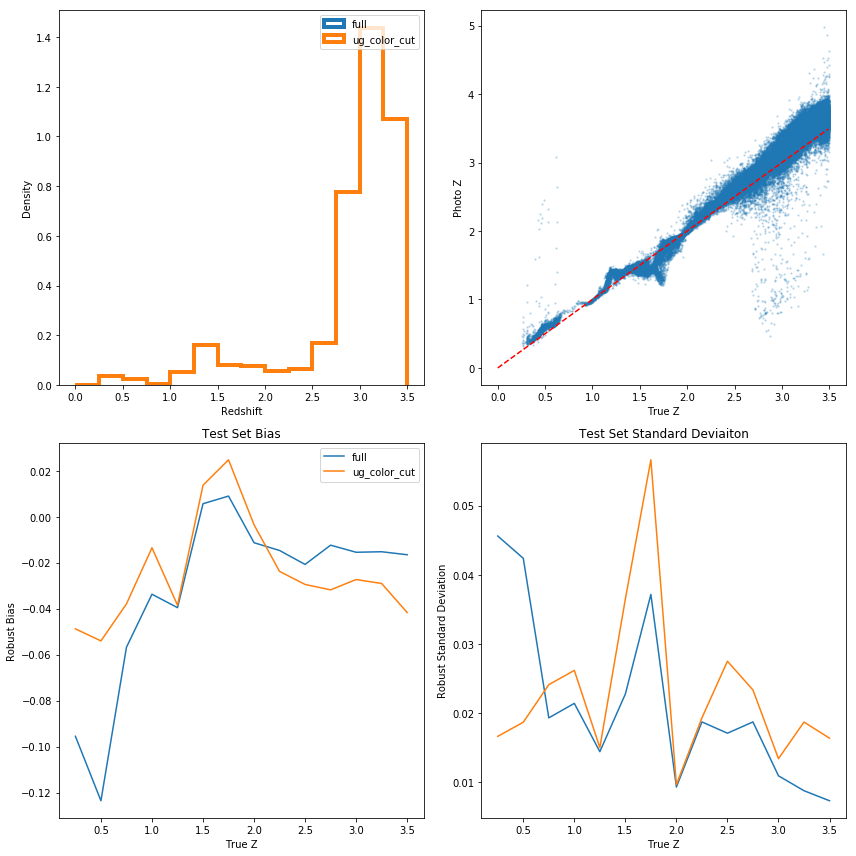

In [84]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df],
                         ['full', 'ug_color_cut'],
                         '../data/compare_mag_cut_r_23.pdf',  scatter_index=1)

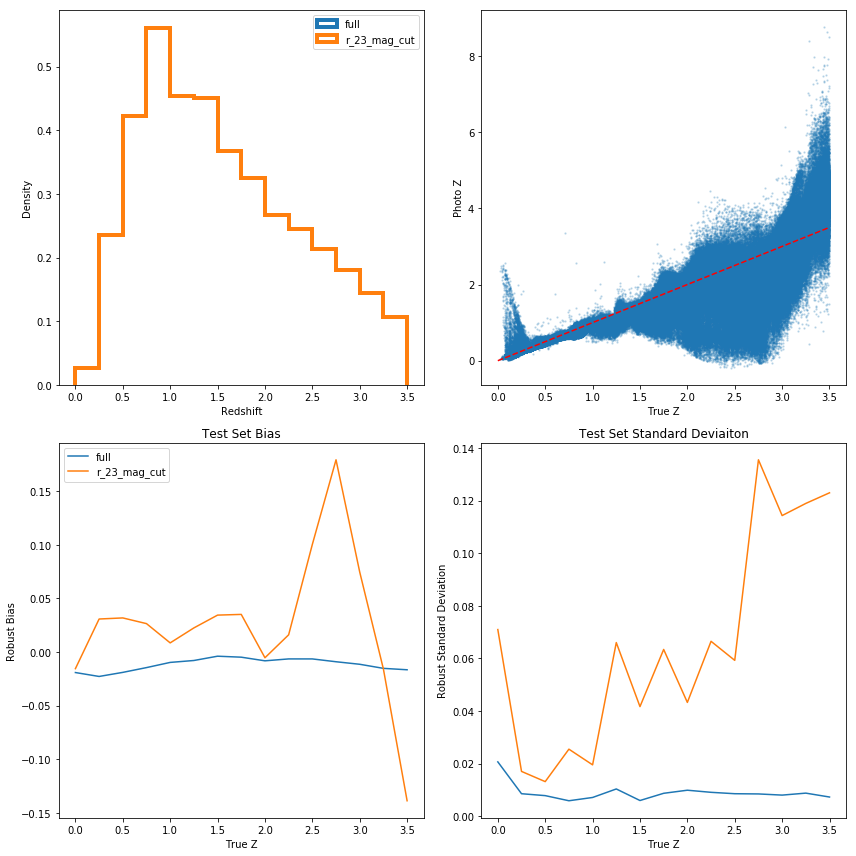

In [86]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df],
                         ['full', 'r_23_mag_cut'],
                         '../data/compare_mag_cut_r_23.pdf',  scatter_index=1)

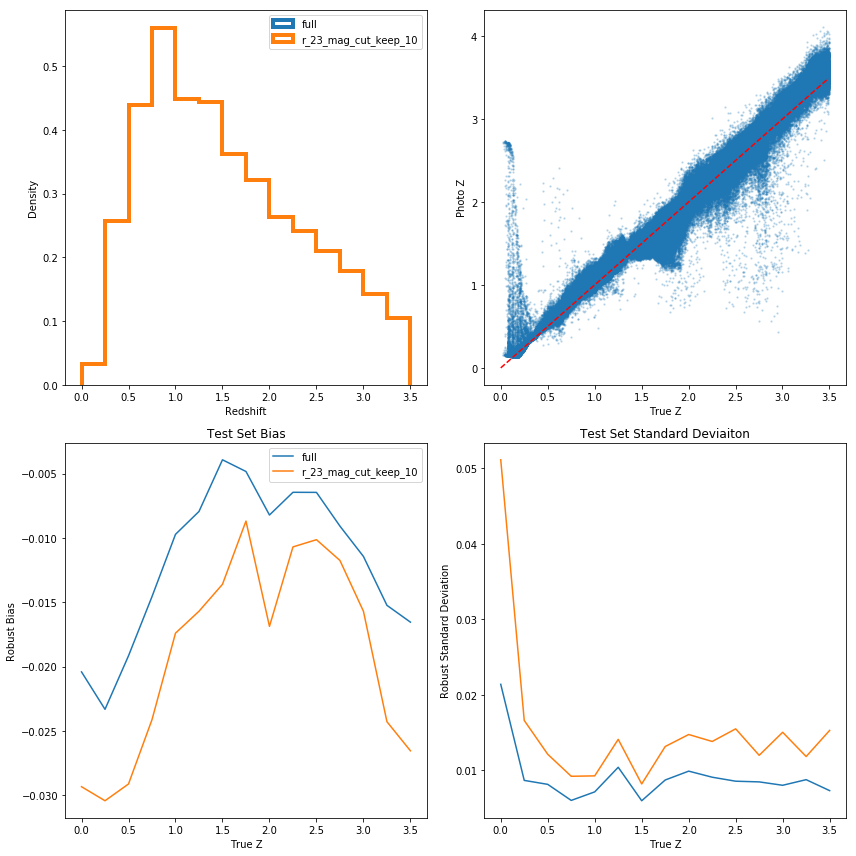

In [88]:
plot_pz.plot_cut_results([test_full_df_color_cut, test_colors_df],
                         ['full', 'r_23_mag_cut_keep_10'],
                         '../data/compare_mag_cut_r_23_keep_10.pdf',  scatter_index=1)

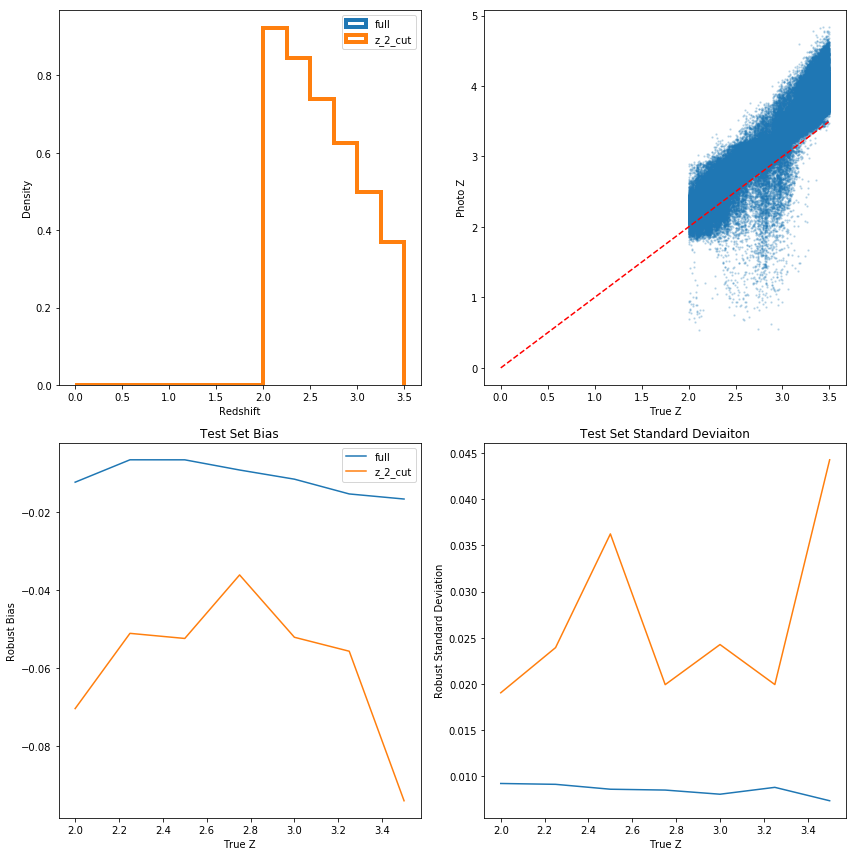

In [80]:
plot_pz.plot_cut_results([test_full_df_redshift_cut, test_redshift_df],
                         ['full', 'z_2_cut'],
                          '../data/compare_redshift_cut.pdf', scatter_index=1)

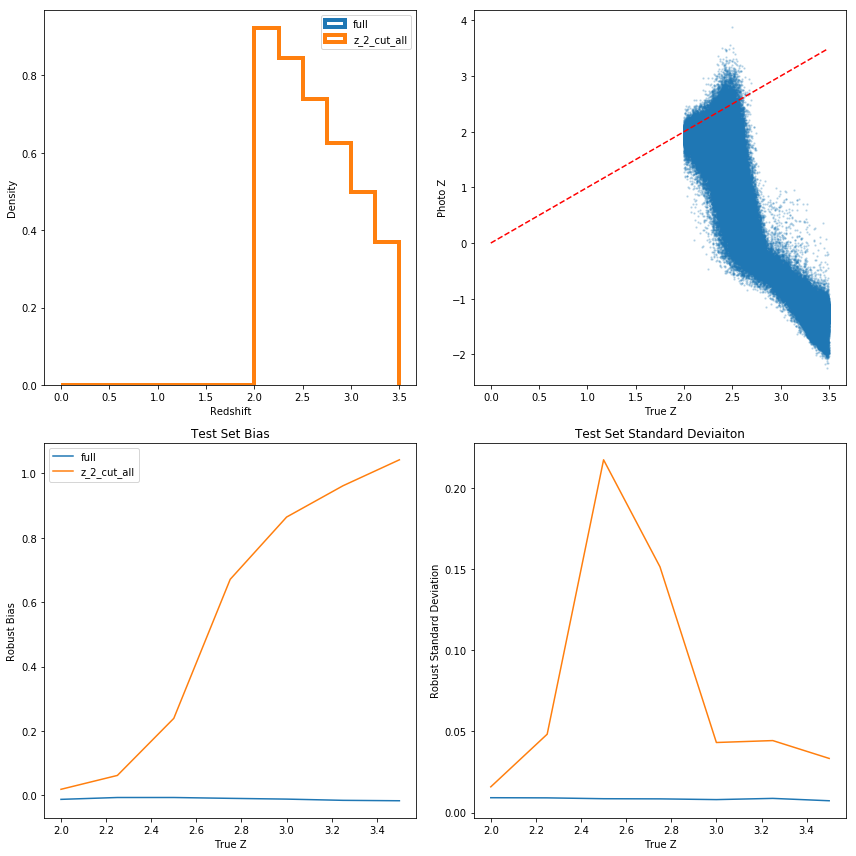

In [82]:
plot_pz.plot_cut_results([test_full_df_redshift_cut, test_redshift_df],
                         ['full', 'z_2_cut_all'],
                          '../data/compare_redshift_cut.pdf', scatter_index=1)

## Calculate error methods

In [89]:
from pz_errors import pz_errors as pze

In [98]:
pz_err = pze()

In [95]:
cat_suffix = 'full'
import pandas as pd
from photoz_nn import photoz_nn
pz_nn = photoz_nn()
train_filename = '../data/train_cat_%s.dat' % cat_suffix
train_colors, train_specz = pz_nn.load_catalog(train_filename)
test_filename = '../data/test_cat_%s.dat' % cat_suffix
test_colors, test_specz = pz_nn.load_catalog(test_filename)

Catalog size: 500000.
Catalog size: 2000000.


In [133]:
full_error = np.genfromtxt('../data/full_error.csv')

In [135]:
sig = full_error/(test_results_dict['full']['photo_z'].iloc[:500000] - 
                  test_results_dict['full']['true_z'].iloc[:500000])

In [136]:
import matplotlib.pyplot as plt
from scipy import stats

Text(0,0.5,'Counts')

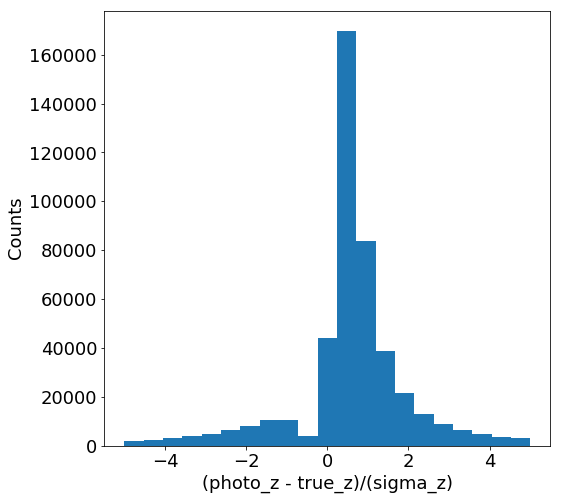

In [137]:
fig = plt.figure(figsize=(8,8))
plt.hist(sig, range=(-5, 5), bins=21)
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('(photo_z - true_z)/(sigma_z)', size=18)
plt.ylabel('Counts', size=18)

In [138]:
np.mean(sig), np.std(sig), stats.skew(sig), np.median(sig), np.percentile(sig, [25, 75])

(1.5410822146064214,
 481.55555022069143,
 402.30709417975567,
 0.5781978376604748,
 array([0.24920313, 1.20094157]))